In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import scipy

from math import sqrt
from glob import glob
from PIL import Image

from skimage.filters import roberts, sobel, scharr, prewitt, gaussian
from skimage.segmentation import active_contour
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.future import graph

%matplotlib inline

In [2]:
path = '/home/ipl/Downloads/0126/train/nc-fish-classification/nc_fish_classification/data/fishfishILOVEYOU/'
#ims = glob(path+'*/*.jpg')
ims = glob(path+'/*.jpg')
len(ims)

29

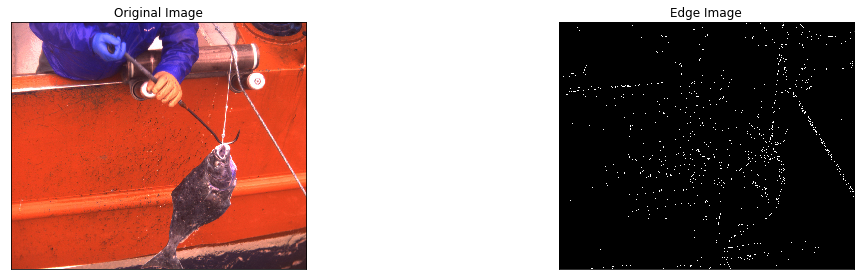

In [3]:
img = cv2.imread(random.choice(ims))

plt.figure(figsize=(18, 10))

edges = cv2.Canny(img, 100, 200)
sub1 = plt.subplot(221)
sub1.imshow(img)
sub1.set_title('Original Image'), sub1.set_xticks([]), sub1.set_yticks([])
sub2 = plt.subplot(222)
sub2.imshow(edges, cmap='gray')
sub2.set_title('Edge Image'), sub2.set_xticks([]), sub2.set_yticks([])
plt.show()



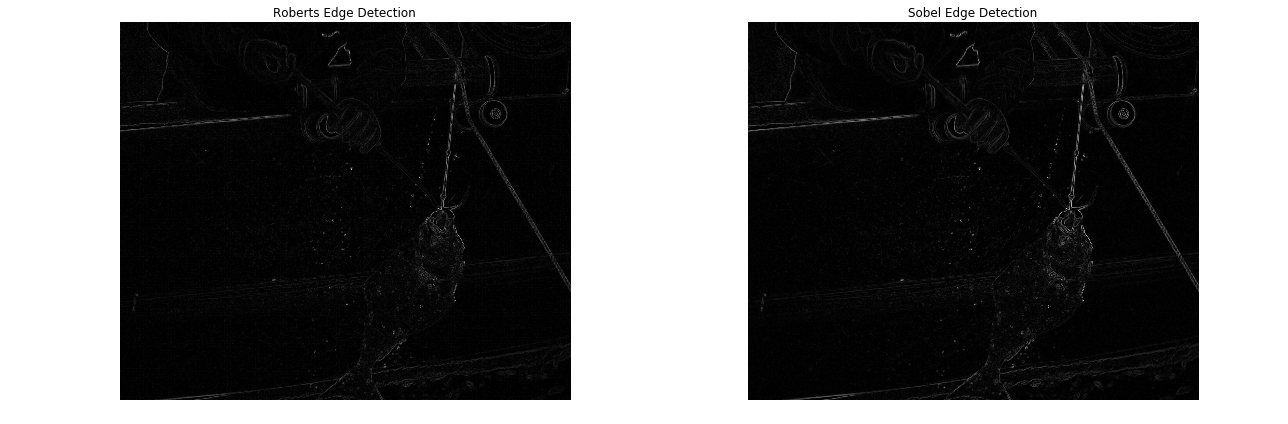

In [4]:
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(18, 6))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


In [5]:
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray, 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


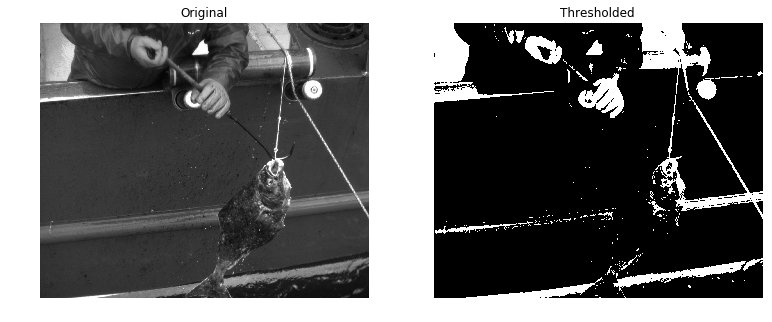

In [6]:
from skimage.filters import threshold_otsu


image = imgray.copy()
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1, adjustable='box-forced')
ax[1] = plt.subplot(1, 3, 2, sharex=ax[0], sharey=ax[0], adjustable='box-forced')

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Thresholded')
ax[1].axis('off')

plt.show()


[[ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


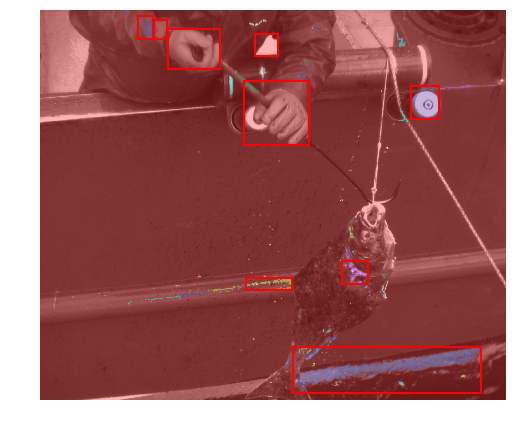

In [7]:
import matplotlib.patches as mpatches

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


image = imgray.copy()

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(5))
print(bw)
# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 3000:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

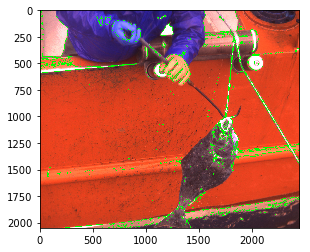

In [8]:
cont_img = img.copy()

plt.imshow(cv2.drawContours(cont_img, contours, -1, (0,255,0), 3))


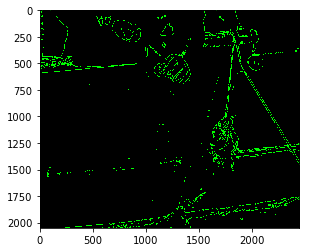

In [9]:
mask = np.zeros_like(cont_img) # Create mask where white is what we want, black otherwise
cv2.drawContours(mask, contours, -1, (0,255,0), 3) # Draw filled contour in mask

out = np.zeros_like(cont_img) # Extract out the object and place into output image
out[mask == 255] = cont_img[mask == 255]

# Show the output image
plt.imshow(out)

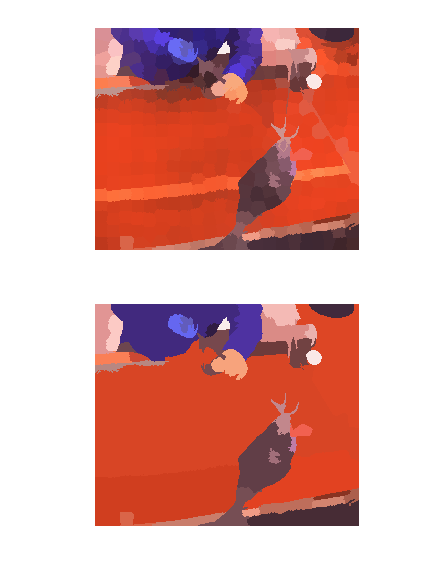

In [10]:
from skimage import data, segmentation, color

reg_img = img.copy()

labels1 = segmentation.slic(reg_img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, reg_img, kind='avg')

g = graph.rag_mean_color(reg_img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, reg_img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()



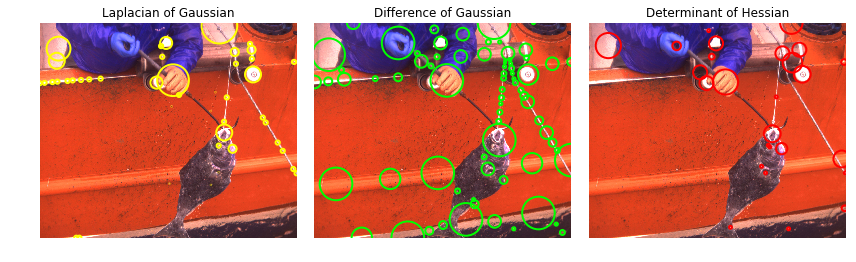

In [11]:
blb_img = img.copy()

blobs_log = blob_log(imgray, max_sigma=120, num_sigma=10, threshold=.2)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(imgray, max_sigma=120, threshold=.5)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(imgray, max_sigma=120, threshold=.005)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(blb_img, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()